In [47]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime
import pickle
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [9]:
tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
    tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', 'USRTOK', tweet) # mention
    tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [25]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


461280


#### Positive Tweets

In [26]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()]
len(smile_tweet)

829183

In [16]:
# size filter
max_length = 60

In [27]:


sad_tweet = list(filter(lambda tweet: len(tweet) < max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) < max_length, smile_tweet))
print(len(smile_tweet))

460574
829162


### Build Dictionary

In [28]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 0

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [29]:
vocabulary_dict.get('URLTOK')

262317

In [14]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 0
        set_array.append(tweet_array)
    return np.array(set_array)

In [31]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(460574, 60)
(829162, 60)


In [32]:
smile_array[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 18, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [33]:
sad_array[0]

array([329, 412,  73, 196,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [34]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0]), np.ones(sad_array.shape[0])), axis=0)

## Prepare Training + Testing Data

In [35]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 0.,  1.,  0., ...,  0.,  1.,  1.])

# Load Pretrain Word2Vec Model (#DIM 52)

In [53]:
# Load pre train Word2vec
wb_matrix = np.load("data/embedding/en_word2vec_52.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embedding/vocabulary_dict_52.pickle", "rb"))
print(len(vocabulary_dict))

(6140853, 52)
423299


In [51]:
len(pickle.load(open("data/embedding/vocabulary_dict_52.pickle", "rb")))

6139582

In [54]:
print(vocabulary_dict.get('USRTOK'))
print(vocabulary_dict_.get('USRTOK'))

262337
None


In [38]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict), wb_matrix.shape[1]))
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    idx = vocabulary_dict_.get(word)
#     print(idx)
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]
        
initW.shape

(423299, 52)

In [39]:
del wb_matrix, vocabulary_dict_

# Distance Supervised Learning

In [95]:
n_input = max_length
n_output = 2
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 50
batch_size = 2048

In [96]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 27, 1, 200)


In [94]:
# with tf.Session() as sess:
#     show_graph(tf.get_default_graph().as_graph_def())
#     # Initialize all variables
#     sess.run(tf.local_variables_initializer())
#     sess.run(tf.global_variables_initializer())
    
#     sess.run(word2vec.assign(initW))# Assign the pretrain word2vec


In [97]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

In [98]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for _ in range(epochs_num):
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        
    distance_supervised_embeddings = sess.run(word2vec)
    

449


## Distance Supervised Learning Comparsion

In [126]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [102]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


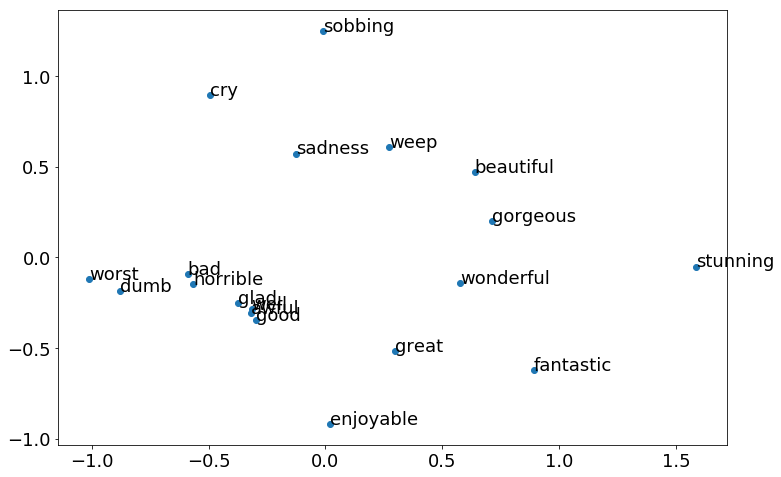

After


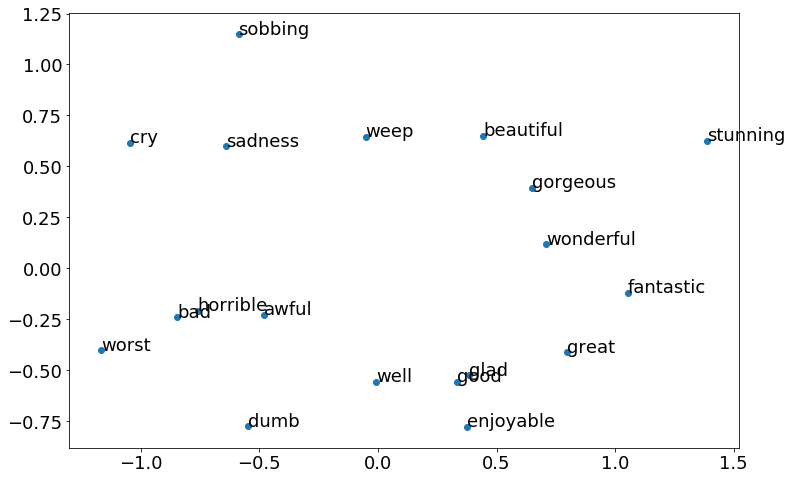

In [127]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict_)
print("After")
draw_plot(words, distance_supervised_embeddings, vocabulary_dict)

### Dump model

In [104]:
np.save('data/embedding/distance_supervised_800K', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_800K.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

### Load model

In [4]:
# Load pre train Word2vec
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_800K.npy")
print(distance_supervised_embeddings.shape)
vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_800K.pickle", "rb"))
print(len(vocabulary_dict))

(423299, 52)
423299


# Supervised Learning

In [5]:
def polarity2label(polarity):
    if polarity =='negative':  return 0
    elif polarity =='neutral': return 1
    elif polarity =='positive':return 2 

In [10]:
# Load Training data
en_train = pd.read_csv('data/supervised_phase/en_full/en_full.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_train.head()

# Load Testing data
en_test = pd.read_csv('data/supervised_phase/en_full/en_test.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_test.head()


,id,lang,polarity,tweet
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...
2,11380,en,negative,If these runway renovations at the airport pre...
3,11381,en,neutral,If you could ask an onstage interview question...
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...


In [11]:
en_train['label'] = en_train['polarity'].map(polarity2label)
en_train.head()

en_test['label'] = en_test['polarity'].map(polarity2label)
en_test.head()

,id,lang,polarity,tweet,label
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",1
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...,1
2,11380,en,negative,If these runway renovations at the airport pre...,0
3,11381,en,neutral,If you could ask an onstage interview question...,1
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...,2


In [18]:
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


In [20]:

tweets_train = word_transform(train_tweet, max_length = max_length)
print(tweets_train.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(tweets_test.shape)

senti_train = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()

(18044, 60)
(20632, 60)


### Build Model

In [22]:
n_input = max_length
n_output = 3
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 500
batch_size = 2048

In [66]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [143]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-17 22:06:45 -    1 epoch, loss:1.042, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-17 22:06:48 -   11 epoch, loss:1.012, train accuracy:0.481, train f1 score:0.323, test f1 score:0.183
2017-11-17 22:06:52 -   21 epoch, loss:0.989, train accuracy:0.526, train f1 score:0.378, test f1 score:0.201
2017-11-17 22:06:55 -   31 epoch, loss:1.000, train accuracy:0.524, train f1 score:0.461, test f1 score:0.535
2017-11-17 22:06:58 -   41 epoch, loss:0.905, train accuracy:0.641, train f1 score:0.587, test f1 score:0.549
2017-11-17 22:07:02 -   51 epoch, loss:0.906, train accuracy:0.635, train f1 score:0.592, test f1 score:0.547
2017-11-17 22:07:05 -   61 epoch, loss:0.880, train accuracy:0.670, train f1 score:0.653, test f1 score:0.582
2017-11-17 22:07:08 -   71 epoch, loss:0.919, train accuracy:0.621, train f1 score:0.612, test f1 score:0.555
2017-11-17 22:07:12 -   81 epoch, loss:0.902, train accuracy:0.648, train f1 score:0.612, test f1 score:0.439
2017-11-17

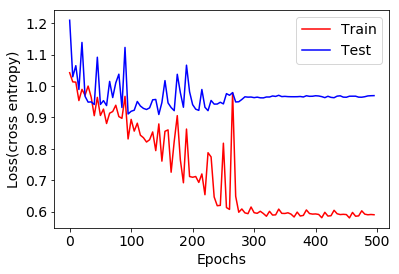

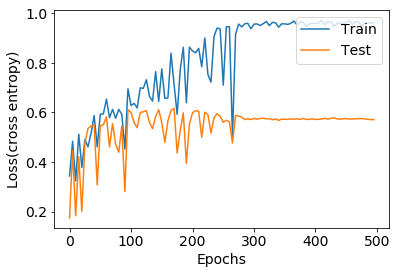

In [140]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()

    

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-17 22:17:43 -    1 epoch, loss:1.042, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-17 22:17:48 -   11 epoch, loss:1.013, train accuracy:0.478, train f1 score:0.314, test f1 score:0.177
2017-11-17 22:17:52 -   21 epoch, loss:0.997, train accuracy:0.523, train f1 score:0.369, test f1 score:0.191
2017-11-17 22:17:56 -   31 epoch, loss:0.982, train accuracy:0.552, train f1 score:0.489, test f1 score:0.551
2017-11-17 22:18:01 -   41 epoch, loss:0.895, train accuracy:0.653, train f1 score:0.598, test f1 score:0.560
2017-11-17 22:18:05 -   51 epoch, loss:0.865, train accuracy:0.685, train f1 score:0.635, test f1 score:0.561
2017-11-17 22:18:09 -   61 epoch, loss:0.863, train accuracy:0.679, train f1 score:0.645, test f1 score:0.584
2017-11-17 22:18:14 -   71 epoch, loss:0.905, train accuracy:0.636, train f1 score:0.621, test f1 score:0.559
2017-11-17 22:18:18 -   81 epoch, loss:0.883, train accuracy:0.660, train f1 score:0.627, test f1 score:0.477
2017-11-17

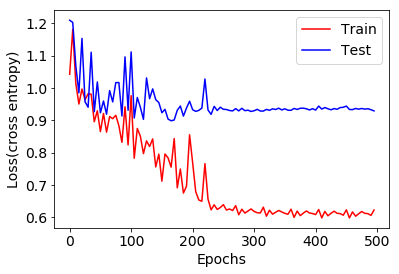

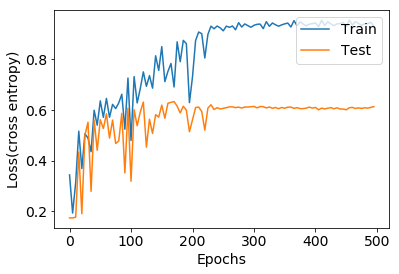

In [144]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()

    

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-21 22:51:02 -    1 epoch, loss:1.184, valid f1 score:0.196, test f1 score:0.174
2017-11-21 22:51:06 -   11 epoch, loss:1.054, valid f1 score:0.256, test f1 score:0.265
2017-11-21 22:51:09 -   21 epoch, loss:0.988, valid f1 score:0.500, test f1 score:0.523
2017-11-21 22:51:13 -   31 epoch, loss:0.971, valid f1 score:0.517, test f1 score:0.535
2017-11-21 22:51:16 -   41 epoch, loss:1.068, valid f1 score:0.340, test f1 score:0.375
2017-11-21 22:51:19 -   51 epoch, loss:0.950, valid f1 score:0.555, test f1 score:0.593
2017-11-21 22:51:23 -   61 epoch, loss:0.960, valid f1 score:0.536, test f1 score:0.583
2017-11-21 22:51:26 -   71 epoch, loss:0.962, valid f1 score:0.516, test f1 score:0.549
2017-11-21 22:51:30 -   81 epoch, loss:0.922, valid f1 score:0.582, test f1 score:0.605
2017-11-21 22:51:33 -   91 epoch, loss:0.916, valid f1 score:0.597, test f1 score:0.601
2017-11-21 22:51:37 -  101 epoch, loss:0.916, valid f1 score:0.609, test f1 score:0.613
2017-11-21 22:51:40 -  111 epoch

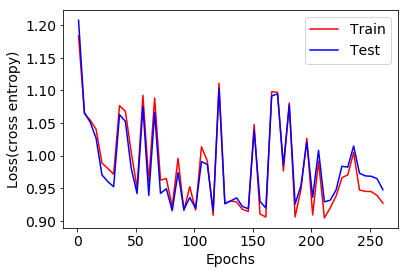

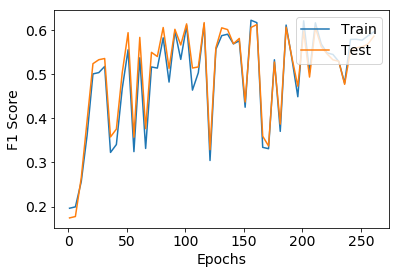

2017-11-21 22:52:32 -    1 epoch, loss:1.006, valid f1 score:0.380, test f1 score:0.335
2017-11-21 22:52:36 -   11 epoch, loss:1.039, valid f1 score:0.354, test f1 score:0.397
2017-11-21 22:52:39 -   21 epoch, loss:0.979, valid f1 score:0.527, test f1 score:0.531
2017-11-21 22:52:42 -   31 epoch, loss:1.125, valid f1 score:0.265, test f1 score:0.300
2017-11-21 22:52:46 -   41 epoch, loss:1.094, valid f1 score:0.325, test f1 score:0.372
2017-11-21 22:52:49 -   51 epoch, loss:0.943, valid f1 score:0.558, test f1 score:0.551
2017-11-21 22:52:53 -   61 epoch, loss:1.126, valid f1 score:0.282, test f1 score:0.321
2017-11-21 22:52:56 -   71 epoch, loss:1.114, valid f1 score:0.316, test f1 score:0.365
2017-11-21 22:52:59 -   81 epoch, loss:0.915, valid f1 score:0.596, test f1 score:0.604
2017-11-21 22:53:03 -   91 epoch, loss:0.916, valid f1 score:0.615, test f1 score:0.615
2017-11-21 22:53:06 -  101 epoch, loss:1.037, valid f1 score:0.444, test f1 score:0.501
2017-11-21 22:53:10 -  111 epoch

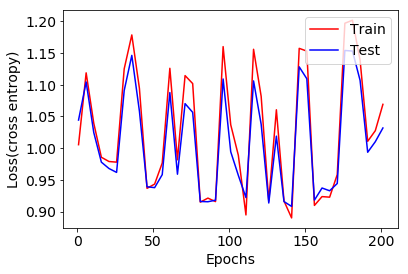

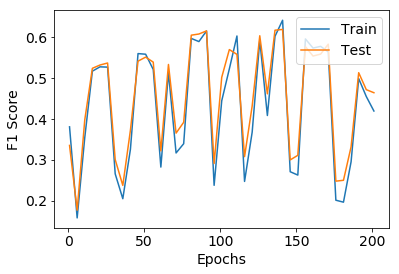

2017-11-21 22:53:41 -    1 epoch, loss:1.214, valid f1 score:0.170, test f1 score:0.174
2017-11-21 22:53:45 -   11 epoch, loss:1.100, valid f1 score:0.173, test f1 score:0.177
2017-11-21 22:53:48 -   21 epoch, loss:0.994, valid f1 score:0.488, test f1 score:0.478
2017-11-21 22:53:52 -   31 epoch, loss:0.967, valid f1 score:0.549, test f1 score:0.527
2017-11-21 22:53:55 -   41 epoch, loss:0.940, valid f1 score:0.572, test f1 score:0.546
2017-11-21 22:53:59 -   51 epoch, loss:1.091, valid f1 score:0.332, test f1 score:0.376
2017-11-21 22:54:02 -   61 epoch, loss:0.980, valid f1 score:0.538, test f1 score:0.562
2017-11-21 22:54:05 -   71 epoch, loss:0.926, valid f1 score:0.612, test f1 score:0.604
2017-11-21 22:54:09 -   81 epoch, loss:1.046, valid f1 score:0.406, test f1 score:0.438
2017-11-21 22:54:12 -   91 epoch, loss:0.917, valid f1 score:0.592, test f1 score:0.593
2017-11-21 22:54:16 -  101 epoch, loss:1.175, valid f1 score:0.209, test f1 score:0.267
2017-11-21 22:54:19 -  111 epoch

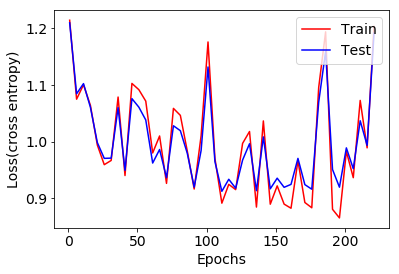

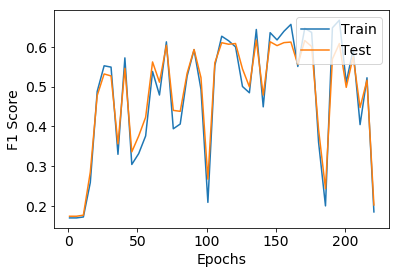

2017-11-21 22:54:58 -    1 epoch, loss:1.088, valid f1 score:0.243, test f1 score:0.174
2017-11-21 22:55:01 -   11 epoch, loss:1.018, valid f1 score:0.334, test f1 score:0.298
2017-11-21 22:55:05 -   21 epoch, loss:0.999, valid f1 score:0.433, test f1 score:0.409
2017-11-21 22:55:08 -   31 epoch, loss:1.028, valid f1 score:0.362, test f1 score:0.336
2017-11-21 22:55:11 -   41 epoch, loss:0.934, valid f1 score:0.554, test f1 score:0.549
2017-11-21 22:55:15 -   51 epoch, loss:1.076, valid f1 score:0.302, test f1 score:0.263
2017-11-21 22:55:18 -   61 epoch, loss:0.984, valid f1 score:0.469, test f1 score:0.442
2017-11-21 22:55:22 -   71 epoch, loss:1.014, valid f1 score:0.399, test f1 score:0.373
2017-11-21 22:55:25 -   81 epoch, loss:0.907, valid f1 score:0.584, test f1 score:0.584
2017-11-21 22:55:29 -   91 epoch, loss:0.927, valid f1 score:0.594, test f1 score:0.581
2017-11-21 22:55:32 -  101 epoch, loss:0.927, valid f1 score:0.558, test f1 score:0.564
2017-11-21 22:55:35 -  111 epoch

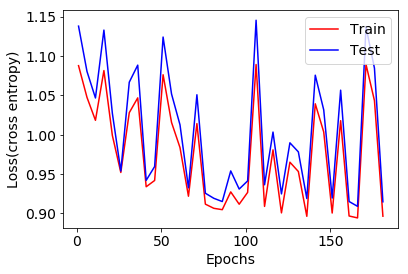

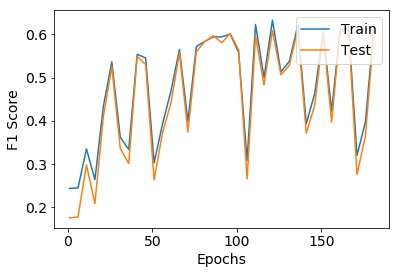

2017-11-21 22:56:00 -    1 epoch, loss:1.151, valid f1 score:0.228, test f1 score:0.174
2017-11-21 22:56:04 -   11 epoch, loss:1.043, valid f1 score:0.268, test f1 score:0.218
2017-11-21 22:56:07 -   21 epoch, loss:1.042, valid f1 score:0.331, test f1 score:0.303
2017-11-21 22:56:11 -   31 epoch, loss:1.020, valid f1 score:0.398, test f1 score:0.381
2017-11-21 22:56:14 -   41 epoch, loss:0.957, valid f1 score:0.527, test f1 score:0.543
2017-11-21 22:56:18 -   51 epoch, loss:1.032, valid f1 score:0.372, test f1 score:0.358
2017-11-21 22:56:21 -   61 epoch, loss:0.942, valid f1 score:0.534, test f1 score:0.550
2017-11-21 22:56:24 -   71 epoch, loss:1.009, valid f1 score:0.434, test f1 score:0.428
2017-11-21 22:56:28 -   81 epoch, loss:0.977, valid f1 score:0.489, test f1 score:0.510
2017-11-21 22:56:31 -   91 epoch, loss:0.917, valid f1 score:0.581, test f1 score:0.604
2017-11-21 22:56:35 -  101 epoch, loss:0.966, valid f1 score:0.504, test f1 score:0.522
2017-11-21 22:56:38 -  111 epoch

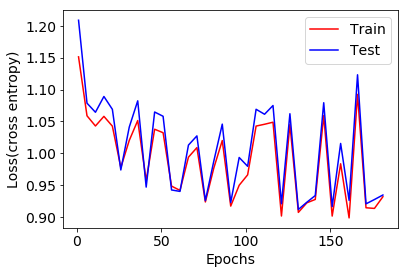

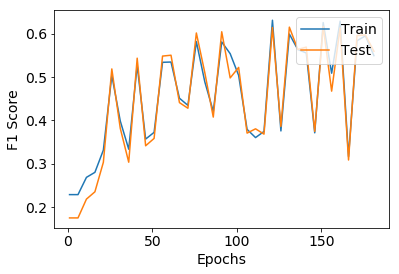

2017-11-21 22:57:03 -    1 epoch, loss:1.109, valid f1 score:0.269, test f1 score:0.174
2017-11-21 22:57:06 -   11 epoch, loss:1.025, valid f1 score:0.400, test f1 score:0.372
2017-11-21 22:57:10 -   21 epoch, loss:1.024, valid f1 score:0.386, test f1 score:0.340
2017-11-21 22:57:13 -   31 epoch, loss:0.997, valid f1 score:0.476, test f1 score:0.520
2017-11-21 22:57:17 -   41 epoch, loss:1.003, valid f1 score:0.474, test f1 score:0.548
2017-11-21 22:57:20 -   51 epoch, loss:0.999, valid f1 score:0.446, test f1 score:0.442
2017-11-21 22:57:24 -   61 epoch, loss:0.995, valid f1 score:0.482, test f1 score:0.553
2017-11-21 22:57:27 -   71 epoch, loss:0.994, valid f1 score:0.481, test f1 score:0.555
2017-11-21 22:57:30 -   81 epoch, loss:0.998, valid f1 score:0.478, test f1 score:0.554
2017-11-21 22:57:34 -   91 epoch, loss:0.982, valid f1 score:0.482, test f1 score:0.492
2017-11-21 22:57:37 -  101 epoch, loss:0.975, valid f1 score:0.536, test f1 score:0.597
2017-11-21 22:57:41 -  111 epoch

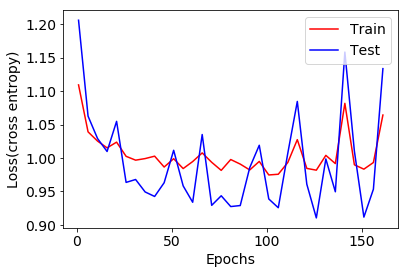

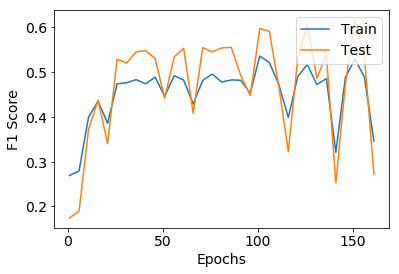

2017-11-21 22:57:59 -    1 epoch, loss:1.014, valid f1 score:0.373, test f1 score:0.174
2017-11-21 22:58:02 -   11 epoch, loss:0.977, valid f1 score:0.453, test f1 score:0.270
2017-11-21 22:58:06 -   21 epoch, loss:0.950, valid f1 score:0.522, test f1 score:0.387
2017-11-21 22:58:09 -   31 epoch, loss:0.948, valid f1 score:0.550, test f1 score:0.497
2017-11-21 22:58:13 -   41 epoch, loss:0.988, valid f1 score:0.489, test f1 score:0.549
2017-11-21 22:58:16 -   51 epoch, loss:0.932, valid f1 score:0.547, test f1 score:0.450
2017-11-21 22:58:19 -   61 epoch, loss:0.937, valid f1 score:0.555, test f1 score:0.520
2017-11-21 22:58:23 -   71 epoch, loss:0.931, valid f1 score:0.545, test f1 score:0.436
2017-11-21 22:58:26 -   81 epoch, loss:0.985, valid f1 score:0.495, test f1 score:0.561
2017-11-21 22:58:30 -   91 epoch, loss:0.922, valid f1 score:0.560, test f1 score:0.501
2017-11-21 22:58:33 -  101 epoch, loss:0.957, valid f1 score:0.543, test f1 score:0.590
2017-11-21 22:58:37 -  111 epoch

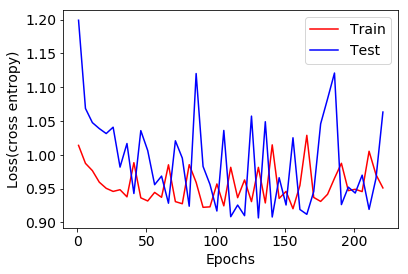

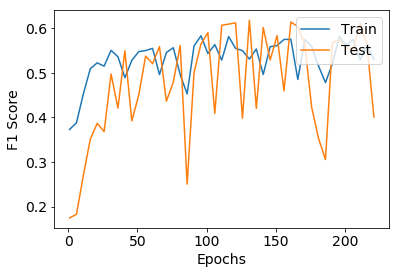

2017-11-21 22:59:15 -    1 epoch, loss:1.031, valid f1 score:0.311, test f1 score:0.174
2017-11-21 22:59:19 -   11 epoch, loss:1.007, valid f1 score:0.420, test f1 score:0.290
2017-11-21 22:59:22 -   21 epoch, loss:0.987, valid f1 score:0.491, test f1 score:0.445
2017-11-21 22:59:26 -   31 epoch, loss:0.976, valid f1 score:0.502, test f1 score:0.477
2017-11-21 22:59:29 -   41 epoch, loss:0.966, valid f1 score:0.507, test f1 score:0.456
2017-11-21 22:59:32 -   51 epoch, loss:0.966, valid f1 score:0.494, test f1 score:0.419
2017-11-21 22:59:36 -   61 epoch, loss:0.982, valid f1 score:0.491, test f1 score:0.554
2017-11-21 22:59:39 -   71 epoch, loss:0.953, valid f1 score:0.521, test f1 score:0.471
2017-11-21 22:59:43 -   81 epoch, loss:0.977, valid f1 score:0.477, test f1 score:0.339
2017-11-21 22:59:46 -   91 epoch, loss:0.938, valid f1 score:0.565, test f1 score:0.490
2017-11-21 22:59:50 -  101 epoch, loss:0.947, valid f1 score:0.551, test f1 score:0.451
2017-11-21 22:59:53 -  111 epoch

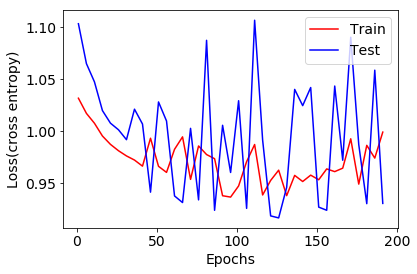

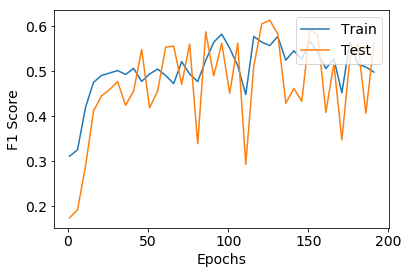

2017-11-21 23:00:21 -    1 epoch, loss:1.197, valid f1 score:0.185, test f1 score:0.335
2017-11-21 23:00:25 -   11 epoch, loss:1.002, valid f1 score:0.351, test f1 score:0.188
2017-11-21 23:00:28 -   21 epoch, loss:0.980, valid f1 score:0.474, test f1 score:0.399
2017-11-21 23:00:32 -   31 epoch, loss:0.972, valid f1 score:0.500, test f1 score:0.441
2017-11-21 23:00:35 -   41 epoch, loss:0.967, valid f1 score:0.493, test f1 score:0.420
2017-11-21 23:00:39 -   51 epoch, loss:0.975, valid f1 score:0.461, test f1 score:0.333
2017-11-21 23:00:42 -   61 epoch, loss:0.967, valid f1 score:0.480, test f1 score:0.392
2017-11-21 23:00:45 -   71 epoch, loss:0.999, valid f1 score:0.501, test f1 score:0.592
2017-11-21 23:00:49 -   81 epoch, loss:0.971, valid f1 score:0.531, test f1 score:0.595
2017-11-21 23:00:52 -   91 epoch, loss:1.001, valid f1 score:0.490, test f1 score:0.591
2017-11-21 23:00:56 -  101 epoch, loss:0.952, valid f1 score:0.544, test f1 score:0.547
2017-11-21 23:00:59 -  111 epoch

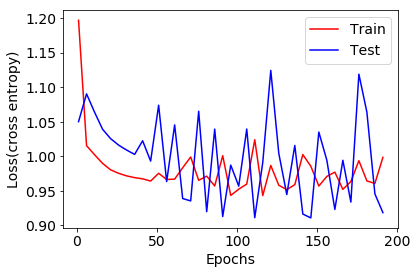

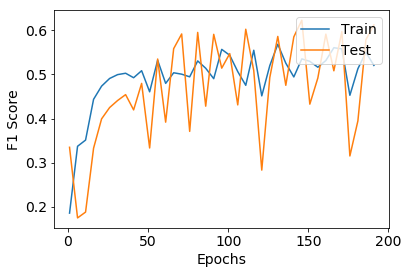

2017-11-21 23:01:28 -    1 epoch, loss:1.053, valid f1 score:0.330, test f1 score:0.174
2017-11-21 23:01:31 -   11 epoch, loss:1.000, valid f1 score:0.354, test f1 score:0.195
2017-11-21 23:01:35 -   21 epoch, loss:0.975, valid f1 score:0.449, test f1 score:0.339
2017-11-21 23:01:38 -   31 epoch, loss:0.967, valid f1 score:0.462, test f1 score:0.368
2017-11-21 23:01:41 -   41 epoch, loss:0.960, valid f1 score:0.502, test f1 score:0.435
2017-11-21 23:01:45 -   51 epoch, loss:0.967, valid f1 score:0.506, test f1 score:0.550
2017-11-21 23:01:48 -   61 epoch, loss:0.951, valid f1 score:0.539, test f1 score:0.526
2017-11-21 23:01:52 -   71 epoch, loss:0.952, valid f1 score:0.560, test f1 score:0.589
2017-11-21 23:01:55 -   81 epoch, loss:0.982, valid f1 score:0.439, test f1 score:0.323
2017-11-21 23:01:59 -   91 epoch, loss:0.972, valid f1 score:0.474, test f1 score:0.371
2017-11-21 23:02:02 -  101 epoch, loss:0.948, valid f1 score:0.564, test f1 score:0.563
2017-11-21 23:02:05 -  111 epoch

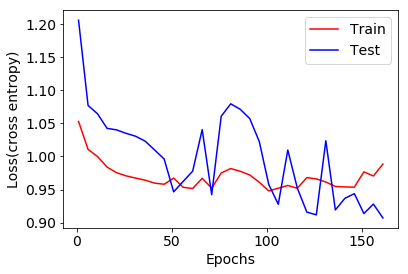

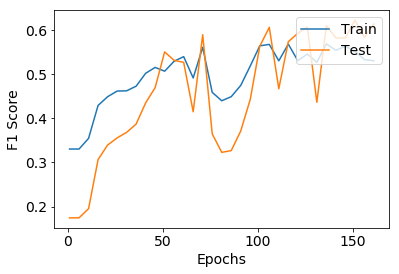

Average Validation F1 Score:0.6001283887483817
Average Testing F1 Score:0.5992078069252005


In [60]:
kf = KFold(n_splits=10)  # indice of 5 fold
saver = tf.train.Saver() # to store the model

early_stop_num = 5
best_valid_f1 = 0.0
best_test_f1 = 0.0

best_train_loss=None
best_test_loss=None
round_best_valid_f1_list = []
round_best_test_f1_list = []
x_axis = np.arange(0., epochs_num, 5)

with tf.Session() as sess:
    for cross_validation_round, (train_index, valid_index) in enumerate(kf.split(tweets_train, senti_train)):
        X_train_folds = tweets_train[train_index]
        y_train_folds = senti_train[train_index]
        X_valid_folds = tweets_train[valid_index]
        y_valid_folds = senti_train[valid_index]
        
        # prepare the training batch
        train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train_folds, y_train_folds)).batch(batch_size).repeat()
        train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
        train_next_batch = train_iterator.get_next()
        
        round_of_epochs = int(tweets_train.shape[0]/batch_size)
        train_loss = []
        test_loss  = []
        train_f1 = []
        test_f1 = []
        local_x_axis = []
        local_best_valid_f1 = 0.0
        local_best_test_f1 = 0.0
        not_better_count = 0
        
        # Initialize all variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec

        for epochs in range(epochs_num): # starting the training process and set the epochs_num
            for _ in range(round_of_epochs):
                train, label = sess.run(train_next_batch) # Get the mini-batch data sample
                sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
            if epochs % 5 ==0:
                loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:X_valid_folds, y:y_valid_folds})
                t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
                train_loss.append(loss)
                test_loss.append(t_loss)
                train_f1.append(f1_score(y_valid_folds, pred, average='weighted'))
                test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
                local_x_axis.append(epochs+1)
            if epochs % 10 ==0:
                print("{} - {:4d} epoch, loss:{:.3f}, valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    loss,
                    f1_score(y_valid_folds, pred, average='weighted'),
                    f1_score(senti_test, t_pred, average='weighted')
                    )
                )
                if train_f1[-1] > local_best_valid_f1:
                    local_best_valid_f1 = train_f1[-1] # assign the best valid value
                    local_best_test_f1 = test_f1[-1] # assign the test value of best valid value
                    not_better_count = 0 # reset the counter
                    
                    # if better then current best one, record it
                    if train_f1[-1] > best_valid_f1:
                        best_valid_f1 = train_f1[-1]
                    if test_f1[-1] > best_test_f1:
                        best_test_f1 = test_f1[-1]
                else:
                    not_better_count += 1
                    if not_better_count > 5:
                        print("No.{} Folds, Early Stop, {} Eopchs, best valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                            cross_validation_round+1,
                            epochs+1,
                            local_best_valid_f1,
                            local_best_test_f1
                        ))
                        round_best_valid_f1_list.append(local_best_valid_f1)
                        round_best_test_f1_list.append(local_best_test_f1)
                        

                        plt.rcParams['font.size'] = 14
                        plt.plot(local_x_axis, train_loss, 'r', local_x_axis, test_loss, 'b')
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss(cross entropy)')
                        plt.show()
                        plt.clf()
                        plt.plot(local_x_axis, train_f1, local_x_axis, test_f1)
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('F1 Score')
                        plt.show()
                        break
print("Average Validation F1 Score:{}\nAverage Testing F1 Score:{}\nAverage Top 5 Testing:{}".format(
            sum(round_best_valid_f1_list)/10.0,
            sum(round_best_test_f1_list)/10.0,
            sum(sorted(round_best_test_f1_list, reverse=True)[:5])/5
        )
     )

In [65]:
# sorted(round_best_valid_f1_list, reverse=True)
sum(sorted(round_best_test_f1_list, reverse=True)[:5])/5# sum(round_best_test_f1_list)/10.0

0.61332932421414621

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-21 23:18:01 -    1 epoch, loss:1.184, valid f1 score:0.196, test f1 score:0.174
2017-11-21 23:18:06 -   11 epoch, loss:1.053, valid f1 score:0.271, test f1 score:0.281
2017-11-21 23:18:10 -   21 epoch, loss:0.982, valid f1 score:0.504, test f1 score:0.531
2017-11-21 23:18:14 -   31 epoch, loss:1.082, valid f1 score:0.307, test f1 score:0.331
2017-11-21 23:18:19 -   41 epoch, loss:0.987, valid f1 score:0.486, test f1 score:0.526
2017-11-21 23:18:23 -   51 epoch, loss:0.928, valid f1 score:0.558, test f1 score:0.569
2017-11-21 23:18:28 -   61 epoch, loss:0.912, valid f1 score:0.597, test f1 score:0.607
2017-11-21 23:18:32 -   71 epoch, loss:1.040, valid f1 score:0.416, test f1 score:0.455
2017-11-21 23:18:36 -   81 epoch, loss:0.958, valid f1 score:0.538, test f1 score:0.567
2017-11-21 23:18:41 -   91 epoch, loss:0.893, valid f1 score:0.622, test f1 score:0.623
2017-11-21 23:18:45 -  101 epoch, loss:0.996, valid f1 score:0.500, test f1 score:0.516
2017-11-21 23:18:49 -  111 epoch

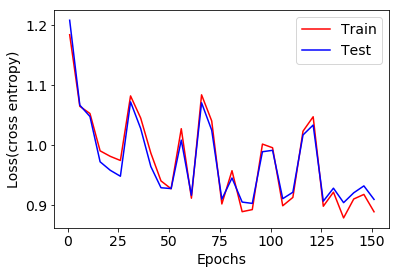

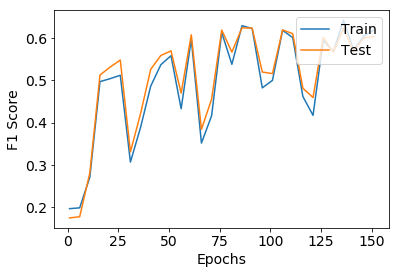

2017-11-21 23:19:08 -    1 epoch, loss:1.005, valid f1 score:0.380, test f1 score:0.335
2017-11-21 23:19:13 -   11 epoch, loss:0.975, valid f1 score:0.522, test f1 score:0.514
2017-11-21 23:19:17 -   21 epoch, loss:0.960, valid f1 score:0.546, test f1 score:0.533
2017-11-21 23:19:21 -   31 epoch, loss:0.948, valid f1 score:0.557, test f1 score:0.555
2017-11-21 23:19:26 -   41 epoch, loss:1.001, valid f1 score:0.491, test f1 score:0.508
2017-11-21 23:19:30 -   51 epoch, loss:0.948, valid f1 score:0.553, test f1 score:0.558
2017-11-21 23:19:34 -   61 epoch, loss:0.936, valid f1 score:0.562, test f1 score:0.562
2017-11-21 23:19:39 -   71 epoch, loss:1.040, valid f1 score:0.435, test f1 score:0.476
2017-11-21 23:19:43 -   81 epoch, loss:0.949, valid f1 score:0.555, test f1 score:0.579
2017-11-21 23:19:48 -   91 epoch, loss:0.877, valid f1 score:0.645, test f1 score:0.618
2017-11-21 23:19:52 -  101 epoch, loss:0.890, valid f1 score:0.635, test f1 score:0.625
2017-11-21 23:19:56 -  111 epoch

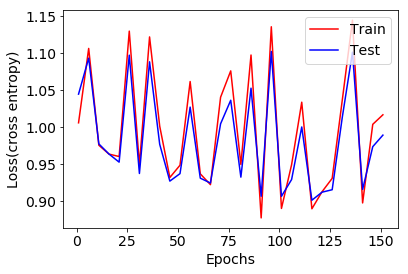

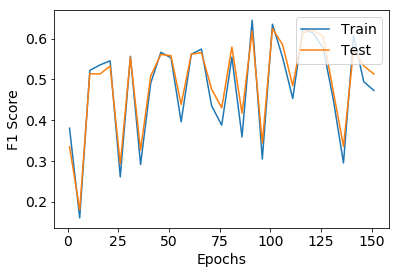

2017-11-21 23:20:15 -    1 epoch, loss:1.213, valid f1 score:0.170, test f1 score:0.174
2017-11-21 23:20:19 -   11 epoch, loss:1.096, valid f1 score:0.177, test f1 score:0.185
2017-11-21 23:20:24 -   21 epoch, loss:0.957, valid f1 score:0.575, test f1 score:0.536
2017-11-21 23:20:28 -   31 epoch, loss:1.059, valid f1 score:0.368, test f1 score:0.392
2017-11-21 23:20:33 -   41 epoch, loss:1.107, valid f1 score:0.309, test f1 score:0.329
2017-11-21 23:20:37 -   51 epoch, loss:0.973, valid f1 score:0.531, test f1 score:0.546
2017-11-21 23:20:41 -   61 epoch, loss:0.951, valid f1 score:0.548, test f1 score:0.539
2017-11-21 23:20:46 -   71 epoch, loss:0.894, valid f1 score:0.620, test f1 score:0.614
2017-11-21 23:20:50 -   81 epoch, loss:1.075, valid f1 score:0.383, test f1 score:0.439
2017-11-21 23:20:55 -   91 epoch, loss:0.882, valid f1 score:0.640, test f1 score:0.623
2017-11-21 23:20:59 -  101 epoch, loss:0.893, valid f1 score:0.642, test f1 score:0.623
2017-11-21 23:21:03 -  111 epoch

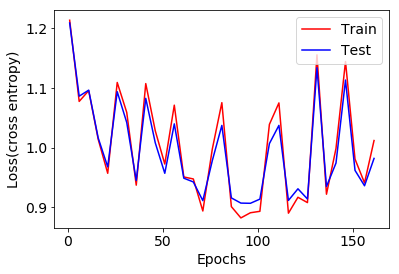

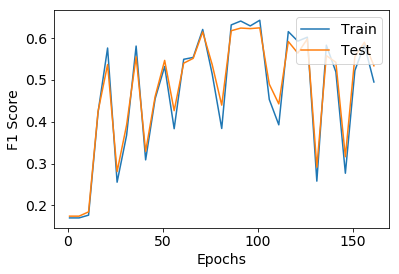

2017-11-21 23:21:27 -    1 epoch, loss:1.058, valid f1 score:0.243, test f1 score:0.174
2017-11-21 23:21:31 -   11 epoch, loss:1.012, valid f1 score:0.354, test f1 score:0.322
2017-11-21 23:21:36 -   21 epoch, loss:0.954, valid f1 score:0.526, test f1 score:0.517
2017-11-21 23:21:40 -   31 epoch, loss:0.931, valid f1 score:0.561, test f1 score:0.553
2017-11-21 23:21:44 -   41 epoch, loss:0.921, valid f1 score:0.568, test f1 score:0.560
2017-11-21 23:21:49 -   51 epoch, loss:0.916, valid f1 score:0.570, test f1 score:0.558
2017-11-21 23:21:53 -   61 epoch, loss:1.012, valid f1 score:0.418, test f1 score:0.386
2017-11-21 23:21:58 -   71 epoch, loss:1.067, valid f1 score:0.328, test f1 score:0.286
2017-11-21 23:22:02 -   81 epoch, loss:0.904, valid f1 score:0.590, test f1 score:0.562
2017-11-21 23:22:06 -   91 epoch, loss:1.030, valid f1 score:0.398, test f1 score:0.358
2017-11-21 23:22:11 -  101 epoch, loss:0.890, valid f1 score:0.598, test f1 score:0.570
2017-11-21 23:22:15 -  111 epoch

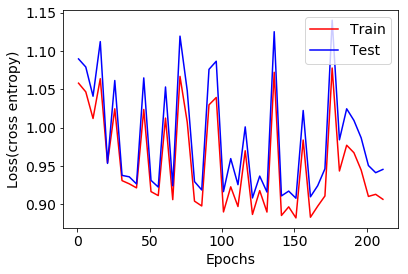

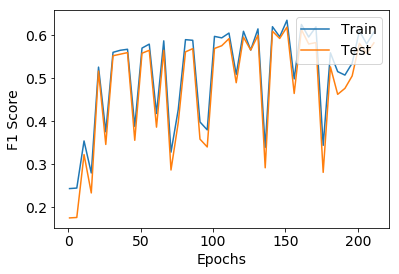

2017-11-21 23:23:01 -    1 epoch, loss:1.151, valid f1 score:0.228, test f1 score:0.174
2017-11-21 23:23:05 -   11 epoch, loss:1.032, valid f1 score:0.325, test f1 score:0.275
2017-11-21 23:23:09 -   21 epoch, loss:0.988, valid f1 score:0.488, test f1 score:0.486
2017-11-21 23:23:14 -   31 epoch, loss:0.968, valid f1 score:0.514, test f1 score:0.533
2017-11-21 23:23:18 -   41 epoch, loss:1.003, valid f1 score:0.440, test f1 score:0.423
2017-11-21 23:23:23 -   51 epoch, loss:0.937, valid f1 score:0.546, test f1 score:0.556
2017-11-21 23:23:27 -   61 epoch, loss:0.924, valid f1 score:0.557, test f1 score:0.569
2017-11-21 23:23:31 -   71 epoch, loss:0.912, valid f1 score:0.583, test f1 score:0.600
2017-11-21 23:23:36 -   81 epoch, loss:0.902, valid f1 score:0.602, test f1 score:0.615
2017-11-21 23:23:40 -   91 epoch, loss:0.940, valid f1 score:0.533, test f1 score:0.535
2017-11-21 23:23:45 -  101 epoch, loss:0.889, valid f1 score:0.635, test f1 score:0.629
2017-11-21 23:23:49 -  111 epoch

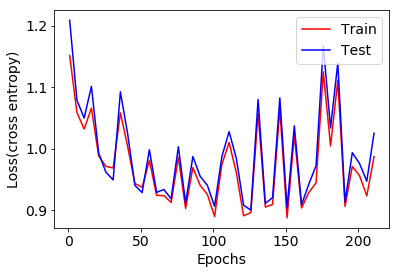

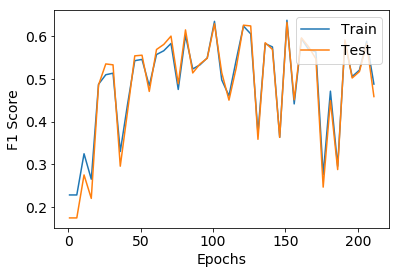

2017-11-21 23:24:34 -    1 epoch, loss:1.109, valid f1 score:0.269, test f1 score:0.174
2017-11-21 23:24:39 -   11 epoch, loss:1.021, valid f1 score:0.402, test f1 score:0.381
2017-11-21 23:24:43 -   21 epoch, loss:1.018, valid f1 score:0.393, test f1 score:0.353
2017-11-21 23:24:48 -   31 epoch, loss:0.992, valid f1 score:0.476, test f1 score:0.488
2017-11-21 23:24:52 -   41 epoch, loss:0.997, valid f1 score:0.479, test f1 score:0.560
2017-11-21 23:24:56 -   51 epoch, loss:0.992, valid f1 score:0.466, test f1 score:0.471
2017-11-21 23:25:01 -   61 epoch, loss:1.002, valid f1 score:0.449, test f1 score:0.427
2017-11-21 23:25:05 -   71 epoch, loss:1.012, valid f1 score:0.430, test f1 score:0.396
2017-11-21 23:25:10 -   81 epoch, loss:0.977, valid f1 score:0.497, test f1 score:0.559
2017-11-21 23:25:14 -   91 epoch, loss:0.979, valid f1 score:0.495, test f1 score:0.513
2017-11-21 23:25:18 -  101 epoch, loss:1.024, valid f1 score:0.427, test f1 score:0.380
2017-11-21 23:25:23 -  111 epoch

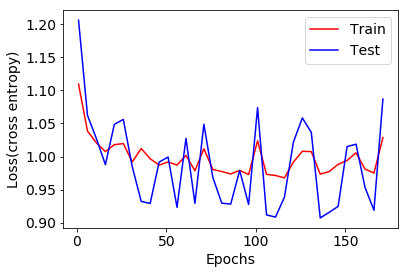

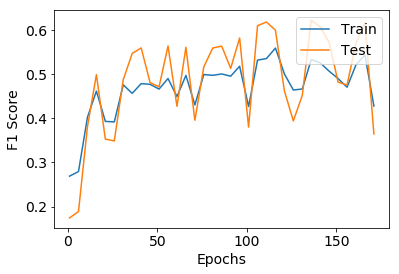

2017-11-21 23:25:51 -    1 epoch, loss:1.014, valid f1 score:0.373, test f1 score:0.174
2017-11-21 23:25:55 -   11 epoch, loss:0.968, valid f1 score:0.488, test f1 score:0.310
2017-11-21 23:25:59 -   21 epoch, loss:0.945, valid f1 score:0.519, test f1 score:0.352
2017-11-21 23:26:04 -   31 epoch, loss:0.935, valid f1 score:0.540, test f1 score:0.405
2017-11-21 23:26:08 -   41 epoch, loss:0.932, valid f1 score:0.560, test f1 score:0.504
2017-11-21 23:26:13 -   51 epoch, loss:0.931, valid f1 score:0.561, test f1 score:0.528
2017-11-21 23:26:17 -   61 epoch, loss:0.981, valid f1 score:0.511, test f1 score:0.571
2017-11-21 23:26:21 -   71 epoch, loss:0.931, valid f1 score:0.536, test f1 score:0.382
2017-11-21 23:26:26 -   81 epoch, loss:0.921, valid f1 score:0.564, test f1 score:0.481
2017-11-21 23:26:30 -   91 epoch, loss:0.920, valid f1 score:0.565, test f1 score:0.515
2017-11-21 23:26:35 -  101 epoch, loss:0.940, valid f1 score:0.585, test f1 score:0.603
2017-11-21 23:26:39 -  111 epoch

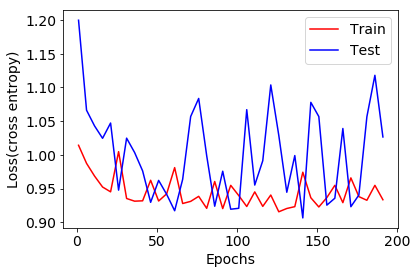

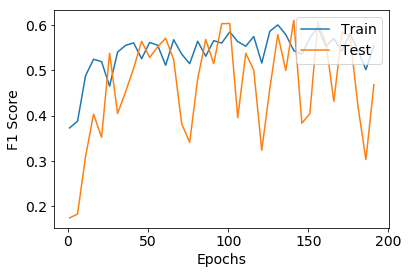

2017-11-21 23:27:16 -    1 epoch, loss:1.030, valid f1 score:0.311, test f1 score:0.174
2017-11-21 23:27:20 -   11 epoch, loss:1.003, valid f1 score:0.447, test f1 score:0.347
2017-11-21 23:27:24 -   21 epoch, loss:0.982, valid f1 score:0.490, test f1 score:0.440
2017-11-21 23:27:29 -   31 epoch, loss:0.973, valid f1 score:0.493, test f1 score:0.410
2017-11-21 23:27:33 -   41 epoch, loss:0.960, valid f1 score:0.522, test f1 score:0.486
2017-11-21 23:27:38 -   51 epoch, loss:1.001, valid f1 score:0.429, test f1 score:0.278
2017-11-21 23:27:42 -   61 epoch, loss:0.996, valid f1 score:0.433, test f1 score:0.294
2017-11-21 23:27:47 -   71 epoch, loss:0.955, valid f1 score:0.534, test f1 score:0.532
2017-11-21 23:27:51 -   81 epoch, loss:0.981, valid f1 score:0.526, test f1 score:0.601
2017-11-21 23:27:55 -   91 epoch, loss:0.972, valid f1 score:0.486, test f1 score:0.360
2017-11-21 23:28:00 -  101 epoch, loss:0.967, valid f1 score:0.501, test f1 score:0.401
2017-11-21 23:28:04 -  111 epoch

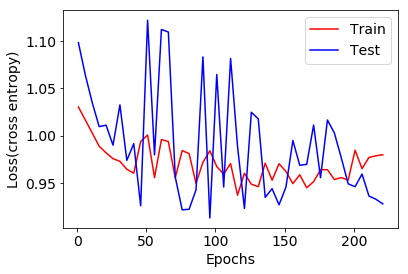

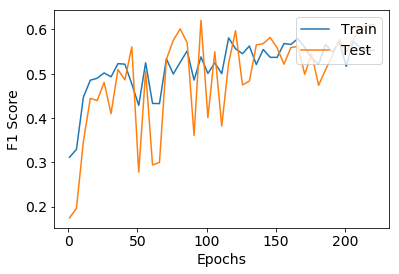

2017-11-21 23:28:54 -    1 epoch, loss:1.197, valid f1 score:0.185, test f1 score:0.335
2017-11-21 23:28:59 -   11 epoch, loss:1.000, valid f1 score:0.353, test f1 score:0.192
2017-11-21 23:29:03 -   21 epoch, loss:0.977, valid f1 score:0.482, test f1 score:0.413
2017-11-21 23:29:07 -   31 epoch, loss:0.969, valid f1 score:0.516, test f1 score:0.494
2017-11-21 23:29:12 -   41 epoch, loss:0.961, valid f1 score:0.511, test f1 score:0.480
2017-11-21 23:29:16 -   51 epoch, loss:0.997, valid f1 score:0.490, test f1 score:0.562
2017-11-21 23:29:21 -   61 epoch, loss:0.999, valid f1 score:0.491, test f1 score:0.562
2017-11-21 23:29:25 -   71 epoch, loss:1.017, valid f1 score:0.466, test f1 score:0.580
2017-11-21 23:29:29 -   81 epoch, loss:0.976, valid f1 score:0.547, test f1 score:0.617
2017-11-21 23:29:34 -   91 epoch, loss:0.942, valid f1 score:0.585, test f1 score:0.569
2017-11-21 23:29:38 -  101 epoch, loss:0.956, valid f1 score:0.540, test f1 score:0.519
2017-11-21 23:29:42 -  111 epoch

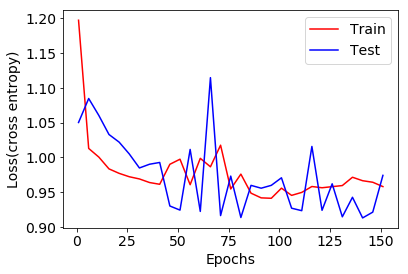

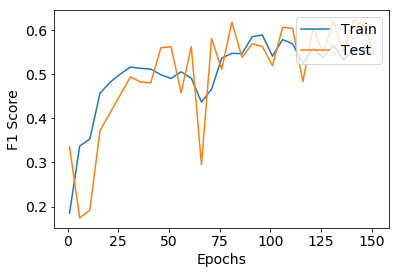

2017-11-21 23:30:02 -    1 epoch, loss:1.053, valid f1 score:0.330, test f1 score:0.174
2017-11-21 23:30:06 -   11 epoch, loss:0.992, valid f1 score:0.385, test f1 score:0.224
2017-11-21 23:30:11 -   21 epoch, loss:0.971, valid f1 score:0.461, test f1 score:0.359
2017-11-21 23:30:15 -   31 epoch, loss:0.961, valid f1 score:0.490, test f1 score:0.412
2017-11-21 23:30:19 -   41 epoch, loss:0.952, valid f1 score:0.527, test f1 score:0.485
2017-11-21 23:30:24 -   51 epoch, loss:0.980, valid f1 score:0.448, test f1 score:0.345
2017-11-21 23:30:28 -   61 epoch, loss:0.978, valid f1 score:0.456, test f1 score:0.367
2017-11-21 23:30:33 -   71 epoch, loss:0.959, valid f1 score:0.517, test f1 score:0.468
2017-11-21 23:30:37 -   81 epoch, loss:0.961, valid f1 score:0.559, test f1 score:0.597
2017-11-21 23:30:41 -   91 epoch, loss:0.965, valid f1 score:0.545, test f1 score:0.613
2017-11-21 23:30:46 -  101 epoch, loss:0.952, valid f1 score:0.561, test f1 score:0.559
2017-11-21 23:30:50 -  111 epoch

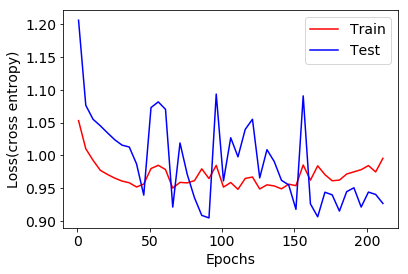

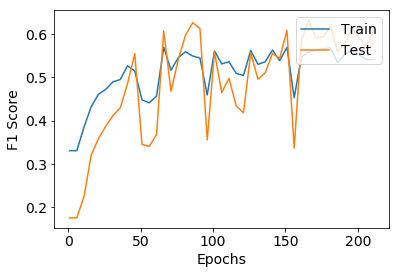

Average Validation F1 Score:0.6038007458949881
Average Testing F1 Score:0.6050300176237744
Average Top 5 Testing:0.6233757757490953


In [67]:
kf = KFold(n_splits=10)  # indice of 5 fold
saver = tf.train.Saver() # to store the model

early_stop_num = 5
best_valid_f1 = 0.0
best_test_f1 = 0.0

best_train_loss=None
best_test_loss=None
round_best_valid_f1_list = []
round_best_test_f1_list = []
x_axis = np.arange(0., epochs_num, 5)

with tf.Session() as sess:
    for cross_validation_round, (train_index, valid_index) in enumerate(kf.split(tweets_train, senti_train)):
        X_train_folds = tweets_train[train_index]
        y_train_folds = senti_train[train_index]
        X_valid_folds = tweets_train[valid_index]
        y_valid_folds = senti_train[valid_index]
        
        # prepare the training batch
        train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train_folds, y_train_folds)).batch(batch_size).repeat()
        train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
        train_next_batch = train_iterator.get_next()
        
        round_of_epochs = int(tweets_train.shape[0]/batch_size)
        train_loss = []
        test_loss  = []
        train_f1 = []
        test_f1 = []
        local_x_axis = []
        local_best_valid_f1 = 0.0
        local_best_test_f1 = 0.0
        not_better_count = 0
        
        # Initialize all variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec

        for epochs in range(epochs_num): # starting the training process and set the epochs_num
            for _ in range(round_of_epochs):
                train, label = sess.run(train_next_batch) # Get the mini-batch data sample
                sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
            if epochs % 5 ==0:
                loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:X_valid_folds, y:y_valid_folds})
                t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
                train_loss.append(loss)
                test_loss.append(t_loss)
                train_f1.append(f1_score(y_valid_folds, pred, average='weighted'))
                test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
                local_x_axis.append(epochs+1)
            if epochs % 10 ==0:
                print("{} - {:4d} epoch, loss:{:.3f}, valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    loss,
                    f1_score(y_valid_folds, pred, average='weighted'),
                    f1_score(senti_test, t_pred, average='weighted')
                    )
                )
                if train_f1[-1] > local_best_valid_f1:
                    local_best_valid_f1 = train_f1[-1] # assign the best valid value
                    local_best_test_f1 = test_f1[-1] # assign the test value of best valid value
                    not_better_count = 0 # reset the counter
                    
                    # if better then current best one, record it
                    if train_f1[-1] > best_valid_f1:
                        best_valid_f1 = train_f1[-1]
                    if test_f1[-1] > best_test_f1:
                        best_test_f1 = test_f1[-1]
                else:
                    not_better_count += 1
                    if not_better_count > 5:
                        print("No.{} Folds, Early Stop, {} Eopchs, best valid f1 score:{:.3f}, test f1 score:{:.3f}".format(
                            cross_validation_round+1,
                            epochs+1,
                            local_best_valid_f1,
                            local_best_test_f1
                        ))
                        round_best_valid_f1_list.append(local_best_valid_f1)
                        round_best_test_f1_list.append(local_best_test_f1)
                        

                        plt.rcParams['font.size'] = 14
                        plt.plot(local_x_axis, train_loss, 'r', local_x_axis, test_loss, 'b')
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss(cross entropy)')
                        plt.show()
                        plt.clf()
                        plt.plot(local_x_axis, train_f1, local_x_axis, test_f1)
                        plt.legend(['Train', 'Test'], loc='upper right')
                        plt.xlabel('Epochs')
                        plt.ylabel('F1 Score')
                        plt.show()
                        break
print("Average Validation F1 Score:{}\nAverage Testing F1 Score:{}\nAverage Top 5 Testing:{}".format(
            sum(round_best_valid_f1_list)/10.0,
            sum(round_best_test_f1_list)/10.0,
            sum(sorted(round_best_test_f1_list, reverse=True)[:5])/5
        )
     )